In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
def generate_random_inputs(ftg_value_count, T):
    arr_temp = np.zeros((1,ftg_value_count))
    

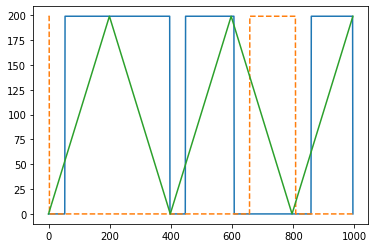

(996, 1)


In [15]:
arr_ftg_u = np.array([[1,2,3,190,10]])
gate_u, gate_u_l, arr_counter, temp, temp = generate_test_array(arr_ftg_u, 200,50)

plot_gate(gate_u, gate_u_l, arr_counter)

print(np.transpose(gate_u).shape)

#print("FTG U:\t\t",arr_ftg_u)
#print("Gate U:\t\t", gate_u)
#print("Gate U Lower:\t", gate_u_l)
#print("Coutner:\t", arr_counter)


In [4]:
def generate_test_array(arr_input, pwm_period, dead_time_setpoint):
    input_ftg_count = arr_input.shape[1]
    
    total_steps = calc_steps_from_periods(input_ftg_count, pwm_period)
    
    arr_counter = generate_counter_array(input_ftg_count, pwm_period)
    max_counter = np.max(arr_counter)
    
    gate_x       = np.zeros((1,total_steps), dtype=int)
    gate_x_l     = np.zeros((1,total_steps), dtype=int)
    # Value to compare locked in value
    lock_ftg_out = np.zeros((1,total_steps), dtype=int)
    # Random value except when ftg value is loaded
    ftg_out      = np.random.uniform(-max_counter, max_counter, (1,total_steps)).astype(int)
    
    increment = 1 # equal to increment counter 

    ftg_index = -1 # initizlize to -1 to set for intial loop
    
    next_gate = 0
    next_gate_l = 1
    
    # Loop throwgh each step
    for index in range(total_steps-1):
        
        current_count = arr_counter[0,index]
        if(current_count == 0 or current_count == max_counter):
            ftg_index += 1  
            ftg_out[0,index] = arr_input[0,ftg_index]
        
        gate_x[0,index] = next_gate
        gate_x_l[0,index] = next_gate_l
        
        next_gate = 0
        next_gate_l = 1
        
        lock_ftg_out[0,index] = arr_input[0,ftg_index]
        
        if(current_count > arr_input[0,ftg_index]):
            #gate_x[0,index]=1
            #gate_x_l[0,index]=0
            next_gate = 1
            next_gate_l = 0
            
       
    set_dead_time =0
    dead_time_count = 0
    
    # go through arrays and add dead times 
    for index in range(1,total_steps-1):
        
        current_gate = gate_x[0,index]
        prev_gate = gate_x[0,index-1]
        prev_gate_l = gate_x_l[0,index-1]
        
        if(set_dead_time == 1):
            # Zero gates and increment dead time counter
            gate_x[0,index] = 0
            gate_x_l[0,index] = 0
            
            dead_time_count += 1
            
            if(dead_time_count >= dead_time_setpoint):
                set_dead_time = 0 
                dead_time_count = 0
            
        ## check that current gate does not equal prev gate and they are not in dead time
        elif(current_gate != prev_gate and not(prev_gate_l==0 and prev_gate==0)):
            set_dead_time = 1
            gate_x[0,index] = 0
            gate_x_l[0,index] = 0
        
    return gate_x, gate_x_l, arr_counter, ftg_out, lock_ftg_out
            

In [5]:
def generate_text_file(arr_ftg_gates, pwm_period, dead_time_setpoint, filePath):
    ### output text file in
    #COL   0        1           2        3      4       5           6      7         8         9          10     11        12
    #     ftg_u  lock_ftg_u  gate_u  gate_u_l  ftg_v  lock_ftg_v  gate_v  gate_v_l  ftg_w  lock_ftg_w  gate_w  gate_w_l  counter
    
    col_num = 13
    
    input_ftg_count = arr_ftg_gates.shape[1]
    total_steps = calc_steps_from_periods(input_ftg_count, pwm_period)
    #print("Total Steps: ", total_steps)
    # Generate zero file
    arr_output = np.zeros((total_steps,col_num), dtype=int)
    
    num_gates = arr_ftg_gates.shape[0]
    
    for index in range(num_gates):
        
        ftg_input = arr_ftg_gates[index,:].reshape((1,arr_ftg_gates.shape[1]))
        
        temp_gate_x,temp_gate_x_l,temp_arr_counter, temp_ftg, temp_lock_ftg = generate_test_array(ftg_input, pwm_period, dead_time_setpoint)
        #print("Gate X Shape: ",temp_gate_x.shape)
        arr_output[:, 4*index]   = np.transpose(temp_ftg[0,:])
        arr_output[:, 4*index+1] = np.transpose(temp_lock_ftg[0,:])
        arr_output[:, 4*index+2] = np.transpose(temp_gate_x[0,:])
        arr_output[:, 4*index+3] = np.transpose(temp_gate_x_l[0,:])
        
        arr_output[:,col_num-1] = np.transpose(temp_arr_counter[0,:])
        
    
    arr_output = arr_output[0:total_steps-1,:]
    
    np.savetxt(filePath, arr_output, fmt='%d')
    
    return arr_output
    

In [6]:
def plot_gate(gate_x, gate_x_l, arr_counter):
    
    %matplotlib inline
    
    # Scale to fit on graph 
    scaled_gate_x = gate_x*np.max(arr_counter)
    scaled_gate_x_l = gate_x_l*np.max(arr_counter)
    
    plt.plot(scaled_gate_x[0,:])
    plt.plot(scaled_gate_x_l[0,:],'--')
    plt.plot(arr_counter[0,:])
    plt.show()
    return

In [7]:
def generate_counter_array(input_ftg_count, pwm_period):
    
    total_steps = calc_steps_from_periods(input_ftg_count, pwm_period)
    
    temp_counter = np.zeros((1,total_steps),dtype=int)
    
    temp_vals = np.arange(pwm_period,dtype=int).reshape((1,pwm_period))
    
    for index in range(input_ftg_count):
        start_index = (pwm_period-1)*index
        end_index = (pwm_period-1)*index+pwm_period
        
        #if index is even increment, else decrement
        if(index % 2 == 0):
            temp_counter[:,start_index:end_index] = temp_vals 
        else:
            temp_counter[:,start_index:end_index-1] = np.flip(temp_vals[:,1:pwm_period])
            
    return temp_counter
    

In [8]:
def calc_steps_from_periods(ftg_count, pwm_period):
    # If arr_input is odd, the arr size is one more for peak value
    if(ftg_count % 2 == 1):
        total_steps = ftg_count * (pwm_period-1) + 1
    else:
        total_steps = ftg_count * (pwm_period-1)
    
    return total_steps

In [9]:
file_path = 'svpwm_test_cases.txt'

# Calculation constants 
sys_clk = 50_000_000 # in Hz
pwm_freq = 100_000     # in Hz
T = int(sys_clk/pwm_freq/2)
Vdc = 200

dead_time_ns = 800
dead_time_cnt = int(sys_clk*dead_time_ns*1e-9)

arr_ftg_u = np.array([[220,100,50]])
arr_ftg_v = np.array([[100,100,100]])
arr_ftg_w = np.array([[100,100,100]])
arr_ftg_comb= np.vstack((arr_ftg_u, arr_ftg_v, arr_ftg_w))

arr_text = generate_text_file(arr_ftg_comb, T, dead_time_cnt, file_path)

print("Period(T): ", T)
print("Dead Time Clock Cycle Count: ", dead_time_cnt)
#print(arr_text)

Period(T):  250
Dead Time Clock Cycle Count:  40
